# data processing


## Cleanse NaN

We analyse the variables with NaN Values how to avoid them. Since we collected Data over a period of 16 years, we have enought data to safely delete this Datapoints.

For timeseries data we simply drop all NaN Datapoints.


In [206]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math 
import seaborn as sns
from pandas.plotting import scatter_matrix

data = pd.read_csv('data/processed/merged_data.csv')
data.reset_index()
data.set_index(['Country', 'Year'])
# rename columns for convenience
data.rename(index=str, columns={'Life expectancy at birth (years)  Both sexes': 'LE_both'}, inplace=True)
data.rename(index=str, columns={'Life expectancy at birth (years)  Male': 'LE_male'}, inplace=True)
data.rename(index=str, columns={'Life expectancy at birth (years)  Female': 'LE_female'}, inplace=True)
print(data.columns[7])
print(data.columns[8])
data.rename(columns={'Current health expenditure (CHE) per capita in US$': 'CHE_in_USD'}, inplace=True)
#data.rename(coludmns={data.columns[8]: 'RnD_ex_pct'}, inplace=True)
#
#display(data.head())
#display(data.describe())

# Income level unknown
# Delete this countries
delcon = data[(data['Income Level']=='Unknown') | (data['Income Level'].isnull())]['Country'].unique().tolist()
delcon.append('Democratic People\'s Republic of Korea')
delcon.append('Somalia')
print(delcon)
data = data[~data['Country'].isin(delcon)]


data.drop(columns=['Last Updated: 11/14/2018', 'Data from database: World Development Indicators'], inplace=True)
#data.drop(columns=['Last Updated: 11/14/2018', 'Data from database: World Development Indicators', 'GNI, PPP (current international $)'], inplace=True)

#data = data[data['Country'] != 'Democratic People\'s Republic of Korea']
#data = data[data['Country'] != 'Sao Tome and Principe']
#data = data[data['Country'] != 'South Sudan']
#data = data[data['Country'] != 'Somalia']

data_bycountry = data.sort_values(by=['Year']).groupby(['Country'])

data_last = data_bycountry.last()


Surface area (sq. km)
Population, total
['Montenegro', 'Sao Tome and Principe', 'Serbia', 'South Sudan', 'Timor-Leste', "Democratic People's Republic of Korea", 'Somalia']


In [207]:


# nan
print(data_last.isnull().sum())

# drop datapoints by county


data_last.drop(columns=['Research and development expenditure (% of GDP)'], inplace=True)
#display(data_last[data_last['CHE_in_USD'].isnull()])

print(data_last.isnull().sum())


Year                                                                       0
LE_both                                                                    0
LE_male                                                                    0
LE_female                                                                  0
Income Level                                                               0
GDP per Capita                                                             0
Surface area (sq. km)                                                      0
Population, total                                                          0
Population density (people per sq. km of land area)                        0
PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)     0
Mortality caused by road traffic injury (per 100,000 people)               0
Intentional homicides (per 100,000 people)                                 0
Individuals using the Internet (% of population)                           0

In [208]:
nans = [[]]
delcol = ['Access to electricity (% of population)', 'CO2 emissions (metric tons per capita)', 'Individuals using the Internet (% of population)', 'Mortality caused by road traffic injury (per 100,000 people)', 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)','Mortality caused by road traffic injury (per 100,000 people)','Research and development expenditure (% of GDP)', 'CHE_in_USD', 'Intentional homicides (per 100,000 people)', 'CO2 emissions (metric tons per capita)', 'Mortality caused by road traffic injury (per 100,000 people)']

#for y, series in data.groupby('Year'):
#    series.fillna(0)
#    print(y)


for col in delcol:
    print(col)
    print(data[col].isnull().sum())
    #display(data[data[col].isnull()])
    data[col].fillna(data[col])
    data[col] = data.groupby('Country').transform(lambda x: x.fillna(x.mean()))

    #'Individuals using the Internet (% of population)', 
d = data.drop(columns=['CO2 emissions (metric tons per capita)'])
#d = data.drop(columns=delcon)
d = d[(d['Year'] >= 2000) & (d['Year'] <= 2018)]

#for name, series in d[(d['Country'] == 'Cuba')].groupby('Year'):
#    print(name)
#    print(series.isnull().sum())
#print(d[(d['Country'] == 'Cuba') & (d['Year'] == 2013)]['GNI per capita, Atlas method (current US$)'])
#d.loc[d['Country'] == 'Cuba' & d['Year'] == 2014], 'GNI per capita, Atlas method (current US$)'] = d[(d['Country'] == 'Cuba') & (d['Year'] == 2013)]['GNI per capita, Atlas method (current US$)']
#print(d[(d['Country'] == 'Cuba') & (d['Year'] == 2014)]['GNI per capita, Atlas method (current US$)'])

#cuba special treatment

d['GDP per Capita'] = data.groupby('Country')['GDP per Capita'].transform(lambda x: x.fillna(x.mean()))
d['GNI, Atlas method (current US$)'] = data.groupby('Country')['GNI, Atlas method (current US$)'].transform(lambda x: x.fillna(x.mean()))
d['GDP per capita growth (annual %)'] = data.groupby('Country')['GDP per capita growth (annual %)'].transform(lambda x: x.fillna(x.mean()))
d['GDP growth (annual %)'] = data.groupby('Country')['GDP per Capita'].transform(lambda x: x.fillna(x.mean()))


# 
delcon = ['Eritrea', 'Syrian Arab Republic', 'Venezuela (Bolivarian Republic of)', 'Djibouti', 'Libya', 'Iraq', 'Afghanistan']
print(delcon)
d = d[~d['Country'].isin(delcon)]


display(d[d['Access to electricity (% of population)'].isnull()])

# CHE_in_USD no data in 2016
# what do?

print(d.isnull().sum())

data_time = d

Access to electricity (% of population)
12
CO2 emissions (metric tons per capita)
356
Individuals using the Internet (% of population)
35
Mortality caused by road traffic injury (per 100,000 people)
2288
PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)
1408
Mortality caused by road traffic injury (per 100,000 people)
0
Research and development expenditure (% of GDP)
1677
CHE_in_USD
198
Intentional homicides (per 100,000 people)
868
CO2 emissions (metric tons per capita)
0
Mortality caused by road traffic injury (per 100,000 people)
0
['Eritrea', 'Syrian Arab Republic', 'Venezuela (Bolivarian Republic of)', 'Djibouti', 'Libya', 'Iraq', 'Afghanistan']


,Country,Year,LE_both,LE_male,LE_female,Income Level,GDP per Capita,Surface area (sq. km),"Population, total",Population density (people per sq. km of land area),...,"Mortality caused by road traffic injury (per 100,000 people)","Intentional homicides (per 100,000 people)",Individuals using the Internet (% of population),"Incidence of tuberculosis (per 100,000 people)","GNI, Atlas method (current US$)",GDP per capita growth (annual %),GDP growth (annual %),Access to electricity (% of population),CHE_in_USD,Research and development expenditure (% of GDP)


Country                                                                   0
Year                                                                      0
LE_both                                                                   0
LE_male                                                                   0
LE_female                                                                 0
Income Level                                                              0
GDP per Capita                                                            0
Surface area (sq. km)                                                     0
Population, total                                                         0
Population density (people per sq. km of land area)                       0
PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)    0
Mortality caused by road traffic injury (per 100,000 people)              0
Intentional homicides (per 100,000 people)                                0
Individuals 

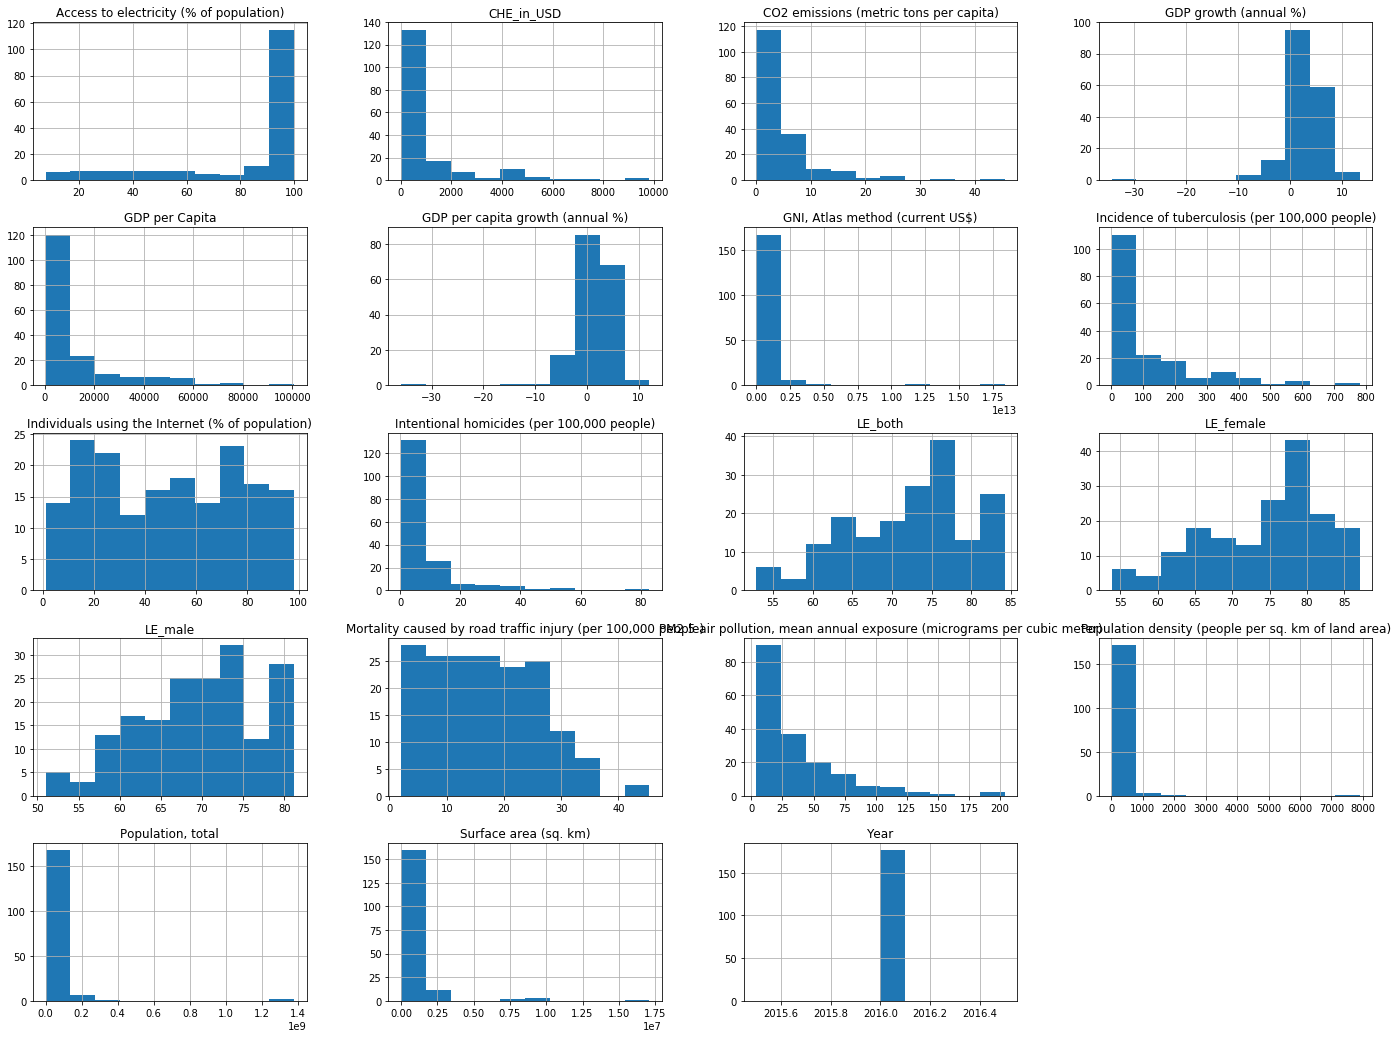

In [209]:
fig = data_last.hist(figsize=(24, 18))
plt.show()

In [210]:
#import seaborn as sns
cols = ['LE_both',
       'Population, total',
       'Population density (people per sq. km of land area)',
       'GDP per Capita', 'Surface area (sq. km)',
       'GNI per capita, Atlas method (current US$)',
       'GDP per capita growth (annual %)', 'GDP growth (annual %)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Mortality caused by road traffic injury (per 100,000 people)',
       'Intentional homicides (per 100,000 people)',
       'Individuals using the Internet (% of population)',
       'Incidence of tuberculosis (per 100,000 people)',
       'CO2 emissions (metric tons per capita)',
       'Access to electricity (% of population)', 'CHE_in_USD']
#sns.pairplot(data_last, kind="scatter", vars=cols, diag_kind='kde')
#plt.show()

* missing values in gdp indicates war or some catastrophy

## Outlier

We detect outliers by plotting histogram and boxplot for every variable and deciding if there are outliers und what du do with them.

For variables with skewed Distribution we Transform the variable

GDP per Capita


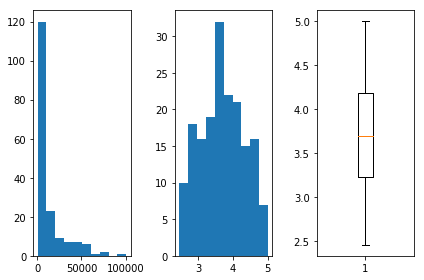

GNI, Atlas method (current US$)


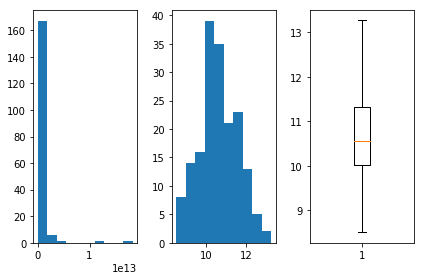

PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)


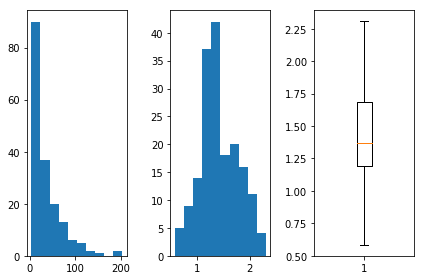

Mortality caused by road traffic injury (per 100,000 people)


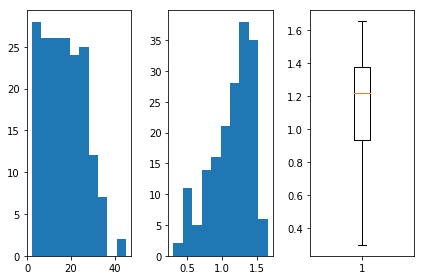

Intentional homicides (per 100,000 people)


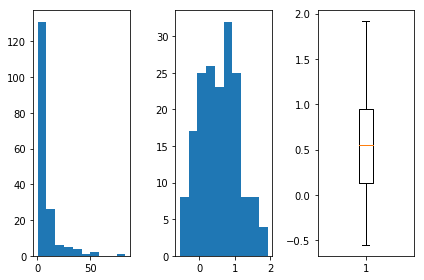

Incidence of tuberculosis (per 100,000 people)


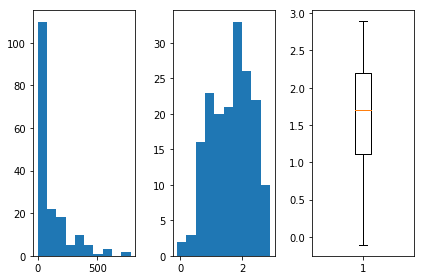

CO2 emissions (metric tons per capita)


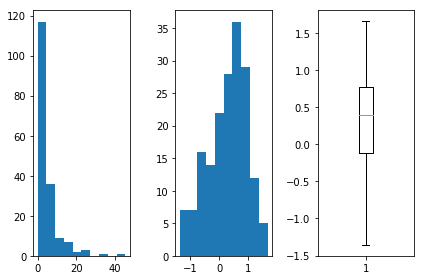

CHE_in_USD


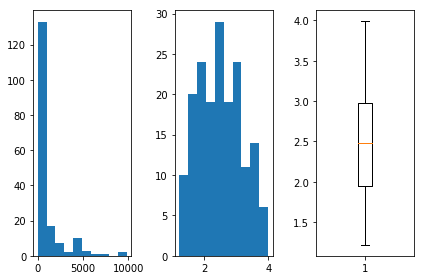

In [211]:
cols = ['GDP per Capita', 
       'GNI, Atlas method (current US$)',
#       'GDP per capita growth (annual %)', 'GDP growth (annual %)',
       'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
       'Mortality caused by road traffic injury (per 100,000 people)',
       'Intentional homicides (per 100,000 people)',
       'Incidence of tuberculosis (per 100,000 people)',
       'CO2 emissions (metric tons per capita)',
       'CHE_in_USD']




def mplt(data1, data2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    n, bins, patches = ax1.hist(data1)
    n, bins, patches = ax2.hist(data2)
    o = ax3.boxplot(data2)
    fig.tight_layout()
    plt.show()

    
    
data_transformed = data_last.copy()


for ser in cols:
    print(ser)
    data_transformed[ser] = data_last[ser].transform(math.log10)
    mplt(data_last[ser], data_transformed[ser])




In [212]:
#cols = ['Individuals using the Internet (% of population)', 
#        'Access to electricity (% of population)']

#data_last[['Individuals using the Internet (% of population)']].hist()

col = 'Access to electricity (% of population)'
#data_transformed[col] = data_last[col].transform(math.exp).copy

data_last[col].describe()

count    176.000000
mean      82.114266
std       27.663835
min        7.588477
25%       67.364519
50%      100.000000
75%      100.000000
max      100.000000
Name: Access to electricity (% of population), dtype: float64

In [213]:
data_last.to_csv('data/processed/data_flat_clean.csv')
data_transformed.to_csv('data/processed/data_flat_clean_transformed.csv')
data_time.to_csv('data/processed/data_time_clean.csv')